In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 54 kB 476 kB/s eta 0:00:01
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=5d920b8022b71500f3cd555fdedaa4008820cff55e1e9785b947911e90cdf56d
  Stored in directory: /root/.cache/pip/wheels/33/f0/c8/218919df808b66696bdb2fbc2261ae74412383483226b0b31d
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=4d65d4dff5c926ef66ebf2fa844dca1dc2b1d882f91b31022db841bbb5fa8d27
  Stored in directory: /root/.cache/pip/wheels/86/1b/58/c23af2fe683acd8edc15d5a1268f0242be1ff2cf827fe34737
Successfully built keras-tuner terminaltables


In [2]:
import pandas as pd
import numpy as np
import glob, os
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.metrics import AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as pyplot

In [100]:
test_dirs = [
    "../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/EURGBP/ALL/EURGBP60/"
    "../demarkindicators/backtest/backtests/results/test_results/AUDUSD/ALL/AUDUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/GBPUSD/ALL/GBPUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/USDCAD/ALL/USDCAD60/",
    "../demarkindicators/backtest/backtests/results/test_results/USDCHF/ALL/USDCHF60/"
]

In [101]:
file_id_list = [
        (os.path.dirname(filename), int(os.path.basename(filename).split(".")[0]))
        for test_dir in test_dirs
        for filename in glob.glob(test_dir + "*.csv") 
        
    ]
file_id_list = sorted(file_id_list, key=lambda tup: tup[1])

In [102]:
data_files, label_files = [], []

for path, file_id in file_id_list:
    data_files.append(os.path.join(path, str(file_id)) + ".csv")
    label_files.append(os.path.join(path, str(file_id)) + ".meta")


In [103]:
print(data_files[0])
print(label_files[0])

../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/1420588800.csv
../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/1420588800.meta


In [104]:
#input_data = []
#for i,datafile in enumerate(data_files):
#    data = np.genfromtxt(datafile, delimiter=',',skip_header=1 )
#    input_data.append(data)

input_data = []
for i,datafile in enumerate(data_files):
    data = np.genfromtxt(datafile, delimiter=',',skip_header=1 )
    input_data.append(data)

In [105]:
df_list = [pd.read_csv(filename) for filename in label_files]
all_labels = pd.concat(df_list, ignore_index=True)
all_labels.head()

,profitable,profit_in_pips,instrument,order_type,time,posix_time
0,0,-1758,EURUSD,BUY,2015-01-07 00:00:00,1420588800
1,0,-165,USDCAD,SELL,2015-01-07 00:00:00,1420588800
2,0,-482,USDCHF,SELL,2015-01-07 00:00:00,1420588800
3,0,-676,GBPUSD,BUY,2015-01-08 00:00:00,1420675200
4,0,-442,USDCAD,SELL,2015-01-09 00:00:00,1420761600


In [106]:
buy_indices = all_labels.index[all_labels['order_type'] == "BUY"].tolist()
sell_indices = all_labels.index[all_labels['order_type'] == "SELL"].tolist()
buy_labels = all_labels.loc[all_labels['order_type'] == "BUY"]["profitable"].values
sell_labels = all_labels.loc[all_labels['order_type'] == "SELL"]["profitable"].values
buy_profits = all_labels.loc[all_labels['order_type'] == "BUY"]["profit_in_pips"].values
sell_profits = all_labels.loc[all_labels['order_type'] == "SELL"]["profit_in_pips"].values
buy_inputs = [input_data[i] for i in buy_indices]
sell_inputs = [input_data[i] for i in sell_indices]

In [107]:
print("% Profitable BUY: {}".format(list(buy_labels).count(1) / len(buy_labels)))
print("% Profitable SELL: {}".format(list(sell_labels).count(1) / len(sell_labels)))

% Profitable BUY: 0.342911877394636
% Profitable SELL: 0.2564102564102564


In [108]:
class FillNaN(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        for a in inputs:
            nan_locations = np.isnan(a)
            a[nan_locations] = 0.0
        return inputs

    def fit(self, inputs):
        pass

In [109]:
class MinMaxer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        scaler = MinMaxScaler(feature_range=(0.0001, 1.0))
        inputs = list(map(lambda inp: scaler.fit_transform(inp), inputs))
        return inputs

    def fit(self, inputs):
        pass


In [110]:
class Transposer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        inputs = list(map(lambda inp: inp.T, inputs))
        return inputs

    def fit(self, inputs):
        pass

In [111]:
class ZeroPad(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        max_len = 0
        for inpd in inputs:
            if len(inpd[0]) > max_len:
                max_len = len(inpd[0])
        inputs = list(map(lambda inp: sequence.pad_sequences(inp, dtype='float32', maxlen=max_len, padding='post'), inputs))
        return inputs

    def fit(self, inputs):
        pass

In [112]:
class Numpy3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        return np.array(inputs)

    def fit(self, inputs):
        pass

In [122]:
pipe = Pipeline(
            steps=
            [
                ('fill_nan', FillNaN()),
                ('min_max',MinMaxer()),
                #('transpose', Transposer()),
                ('zero_pad',ZeroPad()),
                ('numpy_3d', Numpy3D())
            ])

In [123]:
buy_data_pipelined = pipe.transform(buy_inputs)
sell_data_pipelined = pipe.transform(sell_inputs)



In [124]:

# Adopt a different train test split strategy that doubles as forward testing.
# -> Find the index whereat 80% of the trades lies before, use that as training.

train_perc = 0.8
buy_stop_index = round(len(buy_labels) * train_perc)
X_buy_train = buy_data_pipelined[:buy_stop_index]
X_buy_test = buy_data_pipelined[buy_stop_index:]
y_buy_train = buy_labels[:buy_stop_index]
y_buy_test = buy_labels[buy_stop_index:]
profit_buy_train = buy_profits[:buy_stop_index]
profit_buy_test = buy_profits[buy_stop_index:]


sell_stop_index = round(len(sell_labels) * train_perc)
X_sell_train = sell_data_pipelined[:sell_stop_index]
X_sell_test = sell_data_pipelined[sell_stop_index:]
y_sell_train = sell_labels[:sell_stop_index]
y_sell_test = sell_labels[sell_stop_index:]
profit_sell_train = buy_profits[:sell_stop_index]
profit_sell_test = buy_profits[sell_stop_index:]


In [125]:
print(X_buy_train.shape)

(418,)


In [126]:
X_buy_train.shape[2]

IndexError: tuple index out of range

In [60]:
def precision_recall(model, X_test: list, y_test: list, profits: list, verbose=True, threshold=0.5) -> tuple:
    true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
    positives, negatives = list(y_test).count(1), list(y_test).count(0)
    
    print("Analyzing {} samples".format(len(y_test)))
    print("Threshold: {}".format(threshold))
    profit = 0
    for i, (inp, label) in enumerate(zip(X_test, y_test)):
        inp = inp.reshape(1, X_test.shape[1], X_test.shape[2])
        prob_prediction = model.predict([inp], batch_size=1)[0][0]
        class_prediction = model.predict_classes([inp], batch_size=1)[0][0]
        
        
        is_predicted_profitable = True if prob_prediction > threshold else False
        
        if is_predicted_profitable:
            print("Profit: {}".format(profits[i]))
            profit += profits[i]
        
        
        if is_predicted_profitable and label:
            true_positives += 1
        elif not is_predicted_profitable and not label:
            true_negatives += 1
        elif is_predicted_profitable and not label:
            false_positives += 1
        elif not is_predicted_profitable and label:
            false_negatives += 1
            print("False Negative, prob: {}".format(prob_prediction))
        else:
            raise Exception("Error!")
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    if verbose:
        print("The model guessed:")
        print("\t{}/{} profitable trades correctly (true positives)".format(true_positives, positives))
        print("\t{}/{} profitable trades incorrectly (false negatives)".format(false_negatives, positives))
        print("\t{}/{} unprofitable trades correctly (true negatives)".format(true_negatives, negatives))
        print("\t{}/{} unprofitable trades incorrectly (false positives)".format(false_positives, negatives))
        print("\t Precision: {}".format(precision))
        print("\t Recall: {}".format(recall))
        print("\t Profit: {}".format(profit))
    return (precision, recall)



# HyperParameter Tuning for Stacked LSTM

In [91]:
from kerastuner.tuners import RandomSearch


def build_model(hp):
    
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   return_sequences=True, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(
                                hp.Choice('learning_rate',
                                  values=[1e-2, 1e-3, 1e-4])), 
                  metrics=[binary_accuracy])
    
    
    return model


In [95]:
tuner = RandomSearch(
    build_model,
    objective='binary_accuracy',
    max_trials=50,
    executions_per_trial=3,
    allow_new_entries=True)

tuner.search_space_summary()
tuner.search(X_buy_train, y_buy_train, epochs=64)

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 51s - loss: 0.6819 - binary_accuracy: 0.65 - ETA: 23s - loss: 0.6778 - binary_accuracy: 0.62 - ETA: 14s - loss: 0.6708 - binary_accuracy: 0.62 - ETA: 9s - loss: 0.6641 - binary_accuracy: 0.6484 - ETA: 6s - loss: 0.6636 - binary_accuracy: 0.650 - ETA: 4s - loss: 0.6667 - binary_accuracy: 0.640 - ETA: 3s - loss: 0.6693 - binary_accuracy: 0.638 - ETA: 1s - loss: 0.6609 - binary_accuracy: 0.648 - ETA: 1s - loss: 0.6590 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6532 - binary_accuracy: 0.668 - 6s 19ms/sample - loss: 0.6496 - binary_accuracy: 0.6726
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.7308 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6928 - binary_accuracy: 0.609 - ETA: 0s - loss: 0.6422 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6468 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6483 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6673 - binary_accuracy: 0.635 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.5351 - binary_accuracy: 0.750 - ETA: 0s - loss: 0.6109 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6228 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6136 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6067 - binary_accuracy: 0.681 - ETA: 0s - loss: 0.5974 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.5966 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.6050 - binary_accuracy: 0.683 - ETA: 0s - loss: 0.5963 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6078 - binary_accuracy: 0.684 - 1s 3ms/sample - loss: 0.6082 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.7807 - binary_accuracy: 0.500 - ETA: 0s - loss: 0.6946 - binary_accuracy: 0.578 - ETA: 0s - loss: 0.6296 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6106 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6159 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.5963 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5965 - binary_accuracy: 0.683 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 1:06 - loss: 0.7157 - binary_accuracy: 0.468 - ETA: 30s - loss: 0.7043 - binary_accuracy: 0.515 - ETA: 18s - loss: 0.6930 - binary_accuracy: 0.54 - ETA: 11s - loss: 0.6883 - binary_accuracy: 0.55 - ETA: 8s - loss: 0.6824 - binary_accuracy: 0.5750 - ETA: 5s - loss: 0.6810 - binary_accuracy: 0.583 - ETA: 3s - loss: 0.6846 - binary_accuracy: 0.575 - ETA: 2s - loss: 0.6663 - binary_accuracy: 0.617 - ETA: 1s - loss: 0.6646 - binary_accuracy: 0.618 - ETA: 0s - loss: 0.6605 - binary_accuracy: 0.625 - 8s 25ms/sample - loss: 0.6578 - binary_accuracy: 0.6283
Epoch 2/12
339/339 [==============================] - ETA: 1s - loss: 0.6401 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6350 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6115 - binary_accuracy: 0.708 - ETA: 0s - loss: 0.6386 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6430 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6322 - binary_accuracy: 0.677 - ETA: 0s - l

339/339 [==============================] - ETA: 1s - loss: 0.4648 - binary_accuracy: 0.843 - ETA: 0s - loss: 0.5409 - binary_accuracy: 0.765 - ETA: 0s - loss: 0.6092 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6247 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6455 - binary_accuracy: 0.662 - ETA: 0s - loss: 0.6413 - binary_accuracy: 0.661 - ETA: 0s - loss: 0.6269 - binary_accuracy: 0.674 - ETA: 0s - loss: 0.6234 - binary_accuracy: 0.675 - ETA: 0s - loss: 0.6190 - binary_accuracy: 0.680 - ETA: 0s - loss: 0.6172 - binary_accuracy: 0.681 - 1s 4ms/sample - loss: 0.6137 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.5527 - binary_accuracy: 0.750 - ETA: 0s - loss: 0.5759 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5941 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6297 - binary_accuracy: 0.648 - ETA: 0s - loss: 0.6191 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6154 - binary_accuracy: 0.661 - ETA: 0s - loss: 0.6166 - binary_accuracy: 0.660 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 55s - loss: 0.6766 - binary_accuracy: 0.65 - ETA: 14s - loss: 0.6951 - binary_accuracy: 0.48 - ETA: 6s - loss: 0.6981 - binary_accuracy: 0.4563 - ETA: 4s - loss: 0.6971 - binary_accuracy: 0.474 - ETA: 3s - loss: 0.6975 - binary_accuracy: 0.464 - ETA: 1s - loss: 0.6979 - binary_accuracy: 0.453 - ETA: 0s - loss: 0.6984 - binary_accuracy: 0.453 - 6s 19ms/sample - loss: 0.6985 - binary_accuracy: 0.4543
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6796 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6878 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6878 - binary_accuracy: 0.570 - ETA: 0s - loss: 0.6886 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6877 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6853 - binary_accuracy: 0.572 - 1s 2ms/sample - loss: 0.6865 - binary_accuracy: 0.5664
Epoch 3/12
339/339 [==============================] - ETA: 0s - loss: 0.6714 - binary_accuracy: 0.656 - ETA: 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 53s - loss: 0.7128 - binary_accuracy: 0.37 - ETA: 24s - loss: 0.6718 - binary_accuracy: 0.56 - ETA: 14s - loss: 0.6546 - binary_accuracy: 0.59 - ETA: 9s - loss: 0.6468 - binary_accuracy: 0.6172 - ETA: 6s - loss: 0.6707 - binary_accuracy: 0.606 - ETA: 4s - loss: 0.6665 - binary_accuracy: 0.614 - ETA: 1s - loss: 0.6506 - binary_accuracy: 0.632 - ETA: 1s - loss: 0.6426 - binary_accuracy: 0.649 - ETA: 0s - loss: 0.6381 - binary_accuracy: 0.656 - 6s 18ms/sample - loss: 0.6447 - binary_accuracy: 0.6490
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6131 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.6401 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6391 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.6069 - binary_accuracy: 0.706 - ETA: 0s - loss: 0.6084 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6242 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6250 - binary_accuracy: 0.673 - ETA: 0s - loss

339/339 [==============================] - ETA: 1s - loss: 0.5829 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5657 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5570 - binary_accuracy: 0.726 - ETA: 0s - loss: 0.5592 - binary_accuracy: 0.731 - ETA: 0s - loss: 0.5749 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5754 - binary_accuracy: 0.729 - ETA: 0s - loss: 0.5882 - binary_accuracy: 0.721 - 1s 2ms/sample - loss: 0.5875 - binary_accuracy: 0.7168


Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 49s - loss: 0.6932 - binary_accuracy: 0.59 - ETA: 13s - loss: 0.6596 - binary_accuracy: 0.65 - ETA: 8s - loss: 0.6723 - binary_accuracy: 0.6484 - ETA: 5s - loss: 0.6465 - binary_accuracy: 0.675 - ETA: 4s - loss: 0.6401 - binary_accuracy: 0.677 - ETA: 2s - loss: 0.6593 - binary_accuracy: 0.656 - ETA: 1s - loss: 0.6465 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6328 - binary_accuracy: 0.678 - 6s 17ms/sample - loss: 0.6387 - binary_accuracy: 0.6726
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.7214 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6392 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.5920 - binary_accuracy: 0.726 - ETA: 0s - loss: 0.6240 - binary_accuracy: 0.682 - ETA: 0s - loss: 0.6263 - binary_accuracy: 0.678 - ETA: 0s - loss: 0.6246 - binary_accuracy: 0.683 - ETA: 0s - loss: 0.6186 - binary_accuracy: 0.681 - 1s 2ms/sample - loss: 0.6172 - binary_accuracy: 0.6844
Epoch 3/1

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 43s - loss: 0.6779 - binary_accuracy: 0.53 - ETA: 11s - loss: 0.6881 - binary_accuracy: 0.50 - ETA: 5s - loss: 0.6865 - binary_accuracy: 0.5437 - ETA: 2s - loss: 0.6848 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6834 - binary_accuracy: 0.566 - 5s 15ms/sample - loss: 0.6826 - binary_accuracy: 0.5723
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6834 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6547 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6575 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6577 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6595 - binary_accuracy: 0.665 - ETA: 0s - loss: 0.6578 - binary_accuracy: 0.666 - 1s 2ms/sample - loss: 0.6536 - binary_accuracy: 0.6785
Epoch 3/12
339/339 [==============================] - ETA: 0s - loss: 0.6239 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.6390 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6252 - binary_accuracy: 0.725 - ETA: 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 54s - loss: 0.6888 - binary_accuracy: 0.56 - ETA: 24s - loss: 0.6853 - binary_accuracy: 0.60 - ETA: 14s - loss: 0.6371 - binary_accuracy: 0.66 - ETA: 9s - loss: 0.6606 - binary_accuracy: 0.6641 - ETA: 4s - loss: 0.6529 - binary_accuracy: 0.666 - ETA: 1s - loss: 0.6554 - binary_accuracy: 0.652 - ETA: 1s - loss: 0.6494 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6409 - binary_accuracy: 0.675 - 6s 18ms/sample - loss: 0.6281 - binary_accuracy: 0.6873
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.7649 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6948 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6842 - binary_accuracy: 0.662 - ETA: 0s - loss: 0.6735 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6668 - binary_accuracy: 0.669 - ETA: 0s - loss: 0.6596 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6548 - binary_accuracy: 0.673 - ETA: 0s - loss: 0.6523 - binary_accuracy: 0.678 - 1s 2ms/sample 

339/339 [==============================] - ETA: 0s - loss: 0.6547 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.5995 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.5810 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.6184 - binary_accuracy: 0.669 - ETA: 0s - loss: 0.6099 - binary_accuracy: 0.680 - 1s 1ms/sample - loss: 0.6100 - binary_accuracy: 0.6844


Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 59s - loss: 0.6828 - binary_accuracy: 0.59 - ETA: 26s - loss: 0.7250 - binary_accuracy: 0.67 - ETA: 15s - loss: 0.7853 - binary_accuracy: 0.57 - ETA: 7s - loss: 0.7490 - binary_accuracy: 0.5938 - ETA: 4s - loss: 0.7282 - binary_accuracy: 0.609 - ETA: 3s - loss: 0.7163 - binary_accuracy: 0.616 - ETA: 2s - loss: 0.6995 - binary_accuracy: 0.644 - ETA: 1s - loss: 0.6943 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.6867 - binary_accuracy: 0.650 - 7s 20ms/sample - loss: 0.6801 - binary_accuracy: 0.6549
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.7114 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6701 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6809 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6504 - binary_accuracy: 0.664 - ETA: 0s - loss: 0.6481 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6227 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6397 - binary_accuracy: 0.674 - ETA: 0s - loss

Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.5630 - binary_accuracy: 0.781 - ETA: 0s - loss: 0.5929 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.6124 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6113 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.5985 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.5799 - binary_accuracy: 0.729 - ETA: 0s - loss: 0.5827 - binary_accuracy: 0.723 - ETA: 0s - loss: 0.6007 - binary_accuracy: 0.710 - ETA: 0s - loss: 0.6342 - binary_accuracy: 0.681 - 1s 2ms/sample - loss: 0.6312 - binary_accuracy: 0.6844
Epoch 5/12
339/339 [==============================] - ETA: 0s - loss: 0.6293 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5925 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.6171 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6260 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.6258 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.6338 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6324 - binary_accuracy: 0.680 - ETA: 0s - loss: 0.6303 - binary_accur

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 51s - loss: 0.6449 - binary_accuracy: 0.68 - ETA: 23s - loss: 0.6655 - binary_accuracy: 0.67 - ETA: 14s - loss: 0.6794 - binary_accuracy: 0.65 - ETA: 9s - loss: 0.6782 - binary_accuracy: 0.6484 - ETA: 6s - loss: 0.6584 - binary_accuracy: 0.668 - ETA: 4s - loss: 0.6544 - binary_accuracy: 0.671 - ETA: 3s - loss: 0.6484 - binary_accuracy: 0.674 - ETA: 1s - loss: 0.6425 - binary_accuracy: 0.679 - ETA: 1s - loss: 0.6332 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6327 - binary_accuracy: 0.684 - 6s 18ms/sample - loss: 0.6389 - binary_accuracy: 0.6814
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.5987 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6242 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6241 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6172 - binary_accuracy: 0.664 - ETA: 0s - loss: 0.6260 - binary_accuracy: 0.675 - ETA: 0s - loss: 0.6287 - binary_accuracy: 0.666 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.5685 - binary_accuracy: 0.812 - ETA: 0s - loss: 0.6430 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6537 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6418 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6330 - binary_accuracy: 0.662 - ETA: 0s - loss: 0.6122 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.5969 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6092 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6024 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6071 - binary_accuracy: 0.687 - 1s 2ms/sample - loss: 0.6126 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.7479 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6597 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6385 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.6353 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6278 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6320 - binary_accuracy: 0.661 - ETA: 0s - loss: 0.6277 - binary_accuracy: 0.660 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 50s - loss: 0.6972 - binary_accuracy: 0.46 - ETA: 23s - loss: 1.5872 - binary_accuracy: 0.56 - ETA: 13s - loss: 2.0428 - binary_accuracy: 0.50 - ETA: 9s - loss: 1.7026 - binary_accuracy: 0.5312 - ETA: 6s - loss: 1.4884 - binary_accuracy: 0.562 - ETA: 4s - loss: 1.3701 - binary_accuracy: 0.546 - ETA: 3s - loss: 1.2742 - binary_accuracy: 0.540 - ETA: 1s - loss: 1.1934 - binary_accuracy: 0.562 - ETA: 1s - loss: 1.1332 - binary_accuracy: 0.572 - ETA: 0s - loss: 1.0691 - binary_accuracy: 0.600 - 6s 19ms/sample - loss: 1.0369 - binary_accuracy: 0.6106
Epoch 2/12
339/339 [==============================] - ETA: 1s - loss: 0.9299 - binary_accuracy: 0.531 - ETA: 0s - loss: 0.7702 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.7244 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6872 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6705 - binary_accuracy: 0.671 - ETA: 0s - loss

339/339 [==============================] - ETA: 1s - loss: 0.5940 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5866 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.6011 - binary_accuracy: 0.708 - ETA: 0s - loss: 0.6104 - binary_accuracy: 0.695 - ETA: 0s - loss: 0.6017 - binary_accuracy: 0.706 - ETA: 0s - loss: 0.6060 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6210 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6207 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6247 - binary_accuracy: 0.684 - ETA: 0s - loss: 0.6301 - binary_accuracy: 0.678 - 1s 3ms/sample - loss: 0.6260 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 1s - loss: 0.6185 - binary_accuracy: 0.687 - ETA: 1s - loss: 0.6251 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6157 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6164 - binary_accuracy: 0.695 - ETA: 0s - loss: 0.6129 - binary_accuracy: 0.700 - ETA: 0s - loss: 0.6017 - binary_accuracy: 0.713 - ETA: 0s - loss: 0.6103 - binary_accuracy: 0.705 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 57s - loss: 0.7171 - binary_accuracy: 0.40 - ETA: 26s - loss: 0.6446 - binary_accuracy: 0.57 - ETA: 15s - loss: 0.6572 - binary_accuracy: 0.61 - ETA: 10s - loss: 0.6525 - binary_accuracy: 0.64 - ETA: 7s - loss: 0.6535 - binary_accuracy: 0.6375 - ETA: 4s - loss: 0.6439 - binary_accuracy: 0.651 - ETA: 3s - loss: 0.6438 - binary_accuracy: 0.651 - ETA: 2s - loss: 0.6457 - binary_accuracy: 0.648 - ETA: 1s - loss: 0.6411 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6455 - binary_accuracy: 0.650 - 7s 21ms/sample - loss: 0.6499 - binary_accuracy: 0.6460
Epoch 2/12
339/339 [==============================] - ETA: 1s - loss: 0.5830 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5775 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6065 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5962 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6084 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6024 - binary_accuracy: 0.697 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.6540 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6504 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6477 - binary_accuracy: 0.635 - ETA: 0s - loss: 0.6391 - binary_accuracy: 0.664 - ETA: 0s - loss: 0.6431 - binary_accuracy: 0.643 - ETA: 0s - loss: 0.6365 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.6288 - binary_accuracy: 0.642 - ETA: 0s - loss: 0.6129 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6017 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.5952 - binary_accuracy: 0.684 - 1s 3ms/sample - loss: 0.6084 - binary_accuracy: 0.6755
Epoch 4/12
339/339 [==============================] - ETA: 1s - loss: 0.3581 - binary_accuracy: 0.843 - ETA: 0s - loss: 0.6206 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6018 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6021 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6024 - binary_accuracy: 0.693 - ETA: 0s - loss: 0.5971 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6016 - binary_accuracy: 0.692 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 49s - loss: 0.6906 - binary_accuracy: 0.50 - ETA: 22s - loss: 0.6807 - binary_accuracy: 0.57 - ETA: 13s - loss: 0.6775 - binary_accuracy: 0.59 - ETA: 8s - loss: 0.6781 - binary_accuracy: 0.5938 - ETA: 6s - loss: 0.6723 - binary_accuracy: 0.618 - ETA: 4s - loss: 0.6601 - binary_accuracy: 0.651 - ETA: 2s - loss: 0.6483 - binary_accuracy: 0.669 - ETA: 1s - loss: 0.6388 - binary_accuracy: 0.683 - ETA: 1s - loss: 0.6497 - binary_accuracy: 0.663 - ETA: 0s - loss: 0.6509 - binary_accuracy: 0.656 - 6s 18ms/sample - loss: 0.6501 - binary_accuracy: 0.6578
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.5072 - binary_accuracy: 0.812 - ETA: 0s - loss: 0.5292 - binary_accuracy: 0.765 - ETA: 0s - loss: 0.5669 - binary_accuracy: 0.739 - ETA: 0s - loss: 0.5859 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5925 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.6098 - binary_accuracy: 0.692 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.7254 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.6528 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6196 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6247 - binary_accuracy: 0.679 - ETA: 0s - loss: 0.6128 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6111 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.6017 - binary_accuracy: 0.700 - ETA: 0s - loss: 0.5989 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6052 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5976 - binary_accuracy: 0.693 - 1s 3ms/sample - loss: 0.6064 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.5192 - binary_accuracy: 0.812 - ETA: 0s - loss: 0.5034 - binary_accuracy: 0.812 - ETA: 0s - loss: 0.5421 - binary_accuracy: 0.750 - ETA: 0s - loss: 0.5245 - binary_accuracy: 0.765 - ETA: 0s - loss: 0.5499 - binary_accuracy: 0.731 - ETA: 0s - loss: 0.5823 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.5946 - binary_accuracy: 0.687 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 44s - loss: 0.7096 - binary_accuracy: 0.43 - ETA: 20s - loss: 0.6706 - binary_accuracy: 0.59 - ETA: 12s - loss: 1.6182 - binary_accuracy: 0.44 - ETA: 7s - loss: 1.4235 - binary_accuracy: 0.4844 - ETA: 5s - loss: 1.2700 - binary_accuracy: 0.537 - ETA: 3s - loss: 1.1641 - binary_accuracy: 0.562 - ETA: 2s - loss: 1.1008 - binary_accuracy: 0.567 - ETA: 1s - loss: 1.0432 - binary_accuracy: 0.578 - ETA: 0s - loss: 1.0017 - binary_accuracy: 0.583 - ETA: 0s - loss: 0.9598 - binary_accuracy: 0.603 - 5s 16ms/sample - loss: 0.9377 - binary_accuracy: 0.6136
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6602 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6404 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6463 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.6474 - binary_accuracy: 0.648 - ETA: 0s - loss: 0.6520 - binary_accuracy: 0.643 - ETA: 0s - loss: 0.6311 - binary_accuracy: 0.671 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.6941 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6747 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6994 - binary_accuracy: 0.614 - ETA: 0s - loss: 0.6592 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6623 - binary_accuracy: 0.650 - ETA: 0s - loss: 0.6361 - binary_accuracy: 0.682 - ETA: 0s - loss: 0.6313 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6340 - binary_accuracy: 0.683 - ETA: 0s - loss: 0.6363 - binary_accuracy: 0.680 - ETA: 0s - loss: 0.6348 - binary_accuracy: 0.681 - 1s 2ms/sample - loss: 0.6317 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.6585 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6641 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6435 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6250 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6193 - binary_accuracy: 0.693 - ETA: 0s - loss: 0.6315 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.6404 - binary_accuracy: 0.665 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 50s - loss: 0.6965 - binary_accuracy: 0.56 - ETA: 22s - loss: 0.6886 - binary_accuracy: 0.62 - ETA: 13s - loss: 0.6881 - binary_accuracy: 0.58 - ETA: 8s - loss: 0.6915 - binary_accuracy: 0.5469 - ETA: 6s - loss: 0.6916 - binary_accuracy: 0.537 - ETA: 4s - loss: 0.6882 - binary_accuracy: 0.552 - ETA: 2s - loss: 0.6849 - binary_accuracy: 0.571 - ETA: 1s - loss: 0.6847 - binary_accuracy: 0.578 - ETA: 1s - loss: 0.6809 - binary_accuracy: 0.590 - ETA: 0s - loss: 0.6803 - binary_accuracy: 0.593 - 6s 17ms/sample - loss: 0.6773 - binary_accuracy: 0.6018
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.7136 - binary_accuracy: 0.500 - ETA: 0s - loss: 0.6537 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6573 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.6373 - binary_accuracy: 0.695 - ETA: 0s - loss: 0.6239 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.6308 - binary_accuracy: 0.692 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.6147 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6293 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6047 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6138 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6031 - binary_accuracy: 0.706 - ETA: 0s - loss: 0.6230 - binary_accuracy: 0.682 - ETA: 0s - loss: 0.6241 - binary_accuracy: 0.678 - ETA: 0s - loss: 0.6182 - binary_accuracy: 0.683 - ETA: 0s - loss: 0.6114 - binary_accuracy: 0.691 - ETA: 0s - loss: 0.6219 - binary_accuracy: 0.678 - 1s 2ms/sample - loss: 0.6178 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.7190 - binary_accuracy: 0.562 - ETA: 0s - loss: 0.5802 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.6054 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6289 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6181 - binary_accuracy: 0.681 - ETA: 0s - loss: 0.6345 - binary_accuracy: 0.661 - ETA: 0s - loss: 0.6310 - binary_accuracy: 0.665 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 53s - loss: 0.7050 - binary_accuracy: 0.46 - ETA: 24s - loss: 0.6513 - binary_accuracy: 0.64 - ETA: 14s - loss: 0.6409 - binary_accuracy: 0.65 - ETA: 9s - loss: 0.6375 - binary_accuracy: 0.6641 - ETA: 6s - loss: 0.6592 - binary_accuracy: 0.656 - ETA: 4s - loss: 0.6557 - binary_accuracy: 0.661 - ETA: 3s - loss: 0.6499 - binary_accuracy: 0.665 - ETA: 1s - loss: 0.6521 - binary_accuracy: 0.660 - ETA: 1s - loss: 0.6445 - binary_accuracy: 0.670 - ETA: 0s - loss: 0.6528 - binary_accuracy: 0.662 - 6s 19ms/sample - loss: 0.6542 - binary_accuracy: 0.6608
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6577 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6279 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6429 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6533 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6531 - binary_accuracy: 0.637 - ETA: 0s - loss: 0.6510 - binary_accuracy: 0.635 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.5542 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5700 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6092 - binary_accuracy: 0.645 - ETA: 0s - loss: 0.5856 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6034 - binary_accuracy: 0.681 - ETA: 0s - loss: 0.6108 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6141 - binary_accuracy: 0.665 - ETA: 0s - loss: 0.6233 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6215 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6102 - binary_accuracy: 0.668 - 1s 2ms/sample - loss: 0.6107 - binary_accuracy: 0.6726
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.7397 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.7150 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.7277 - binary_accuracy: 0.572 - ETA: 0s - loss: 0.6951 - binary_accuracy: 0.609 - ETA: 0s - loss: 0.6617 - binary_accuracy: 0.650 - ETA: 0s - loss: 0.6439 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6448 - binary_accuracy: 0.665 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 44s - loss: 0.6692 - binary_accuracy: 0.59 - ETA: 20s - loss: 0.6054 - binary_accuracy: 0.70 - ETA: 11s - loss: 0.5957 - binary_accuracy: 0.71 - ETA: 7s - loss: 0.6307 - binary_accuracy: 0.7031 - ETA: 5s - loss: 0.6631 - binary_accuracy: 0.687 - ETA: 3s - loss: 0.6589 - binary_accuracy: 0.687 - ETA: 2s - loss: 0.6469 - binary_accuracy: 0.696 - ETA: 1s - loss: 0.6400 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6466 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6508 - binary_accuracy: 0.675 - 5s 16ms/sample - loss: 0.6503 - binary_accuracy: 0.6726
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6547 - binary_accuracy: 0.593 - ETA: 0s - loss: 0.6342 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6419 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6303 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6324 - binary_accuracy: 0.643 - ETA: 0s - loss: 0.6461 - binary_accuracy: 0.635 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.5948 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5974 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.6109 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.5998 - binary_accuracy: 0.726 - ETA: 0s - loss: 0.6030 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.6093 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6058 - binary_accuracy: 0.705 - ETA: 0s - loss: 0.6124 - binary_accuracy: 0.695 - ETA: 0s - loss: 0.6139 - binary_accuracy: 0.694 - ETA: 0s - loss: 0.6157 - binary_accuracy: 0.687 - 1s 2ms/sample - loss: 0.6151 - binary_accuracy: 0.6873
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.6176 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6547 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6252 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6296 - binary_accuracy: 0.671 - ETA: 0s - loss: 0.6327 - binary_accuracy: 0.662 - ETA: 0s - loss: 0.6277 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.6235 - binary_accuracy: 0.669 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 45s - loss: 0.6828 - binary_accuracy: 0.56 - ETA: 20s - loss: 1.0268 - binary_accuracy: 0.65 - ETA: 12s - loss: 1.5573 - binary_accuracy: 0.55 - ETA: 8s - loss: 1.3388 - binary_accuracy: 0.5625 - ETA: 5s - loss: 1.2081 - binary_accuracy: 0.575 - ETA: 4s - loss: 1.0977 - binary_accuracy: 0.609 - ETA: 2s - loss: 1.0244 - binary_accuracy: 0.625 - ETA: 1s - loss: 0.9906 - binary_accuracy: 0.617 - ETA: 0s - loss: 0.9443 - binary_accuracy: 0.631 - ETA: 0s - loss: 0.9050 - binary_accuracy: 0.646 - 6s 17ms/sample - loss: 0.8917 - binary_accuracy: 0.6460
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6508 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6611 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6507 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6463 - binary_accuracy: 0.664 - ETA: 0s - loss: 0.6463 - binary_accuracy: 0.662 - ETA: 0s - loss: 0.6340 - binary_accuracy: 0.677 - ETA: 0s - loss

339/339 [==============================] - ETA: 0s - loss: 0.6034 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5657 - binary_accuracy: 0.781 - ETA: 0s - loss: 0.5873 - binary_accuracy: 0.750 - ETA: 0s - loss: 0.6128 - binary_accuracy: 0.710 - ETA: 0s - loss: 0.6220 - binary_accuracy: 0.700 - ETA: 0s - loss: 0.6235 - binary_accuracy: 0.697 - ETA: 0s - loss: 0.6194 - binary_accuracy: 0.700 - ETA: 0s - loss: 0.6283 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6248 - binary_accuracy: 0.691 - ETA: 0s - loss: 0.6227 - binary_accuracy: 0.693 - 1s 3ms/sample - loss: 0.6291 - binary_accuracy: 0.6844
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.6237 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6422 - binary_accuracy: 0.656 - ETA: 0s - loss: 0.6362 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6576 - binary_accuracy: 0.640 - ETA: 0s - loss: 0.6398 - binary_accuracy: 0.668 - ETA: 0s - loss: 0.6316 - binary_accuracy: 0.677 - ETA: 0s - loss: 0.6389 - binary_accuracy: 0.665 

Train on 339 samples
Epoch 1/12
339/339 [==============================] - ETA: 47s - loss: 0.7138 - binary_accuracy: 0.46 - ETA: 21s - loss: 0.6486 - binary_accuracy: 0.64 - ETA: 13s - loss: 0.6875 - binary_accuracy: 0.64 - ETA: 8s - loss: 0.6272 - binary_accuracy: 0.6953 - ETA: 6s - loss: 0.6416 - binary_accuracy: 0.687 - ETA: 4s - loss: 0.6387 - binary_accuracy: 0.687 - ETA: 2s - loss: 0.6401 - binary_accuracy: 0.683 - ETA: 1s - loss: 0.6445 - binary_accuracy: 0.664 - ETA: 1s - loss: 0.6510 - binary_accuracy: 0.638 - ETA: 0s - loss: 0.6554 - binary_accuracy: 0.625 - 6s 18ms/sample - loss: 0.6533 - binary_accuracy: 0.6313
Epoch 2/12
339/339 [==============================] - ETA: 0s - loss: 0.6058 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.7644 - binary_accuracy: 0.578 - ETA: 0s - loss: 0.7100 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.7017 - binary_accuracy: 0.632 - ETA: 0s - loss: 0.7001 - binary_accuracy: 0.625 - ETA: 0s - loss: 0.6808 - binary_accuracy: 0.645 - ETA: 0s - loss

339/339 [==============================] - ETA: 1s - loss: 0.6104 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5908 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.6167 - binary_accuracy: 0.666 - ETA: 0s - loss: 0.6021 - binary_accuracy: 0.664 - ETA: 0s - loss: 0.6097 - binary_accuracy: 0.675 - ETA: 0s - loss: 0.5942 - binary_accuracy: 0.692 - ETA: 0s - loss: 0.5937 - binary_accuracy: 0.687 - ETA: 0s - loss: 0.6110 - binary_accuracy: 0.675 - ETA: 0s - loss: 0.6193 - binary_accuracy: 0.670 - ETA: 0s - loss: 0.6081 - binary_accuracy: 0.681 - 1s 3ms/sample - loss: 0.6150 - binary_accuracy: 0.6755
Epoch 4/12
339/339 [==============================] - ETA: 0s - loss: 0.5588 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.5553 - binary_accuracy: 0.734 - ETA: 0s - loss: 0.5849 - binary_accuracy: 0.718 - ETA: 0s - loss: 0.6020 - binary_accuracy: 0.695 - ETA: 0s - loss: 0.5946 - binary_accuracy: 0.712 - ETA: 0s - loss: 0.6025 - binary_accuracy: 0.703 - ETA: 0s - loss: 0.6019 - binary_accuracy: 0.709 

INFO:tensorflow:Oracle triggered exit


In [96]:
tuner.results_summary()

In [102]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
precision_recall(best_model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.65)     

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 96)            86784     
_________________________________________________________________
dropout (Dropout)            (None, 10, 96)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 96)            74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9

(0.3333333333333333, 0.08333333333333333)

# Basic LSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 75)                62700     
_________________________________________________________________
dropout_9 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 76        
Total params: 62,776
Trainable params: 62,776
Non-trainable params: 0
_________________________________________________________________
None
Train on 418 samples
Epoch 1/32
418/418 - 5s - loss: 0.6714 - accuracy: 0.6100
Epoch 2/32
418/418 - 3s - loss: 0.6506 - accuracy: 0.6459
Epoch 3/32
418/418 - 3s - loss: 0.6521 - accuracy: 0.6340
Epoch 4/32
418/418 - 3s - loss: 0.6281 - accuracy: 0.6603
Epoch 5/32
418/418 - 3s - loss: 0.6285 - accuracy: 0.6603
Epoch 6/32
418/418 - 3s - loss: 0.6225 - accuracy: 0.6794
Epoch 

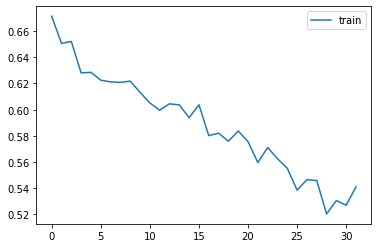

In [73]:
model = Sequential()
model.add(LSTM(75, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=32, batch_size=2, verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [75]:
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.4)     

Analyzing 104 samples
Threshold: 0.4
Profit: 1224
False Negative, prob: 0.19841518998146057
Profit: 1550
False Negative, prob: 0.21484872698783875
False Negative, prob: 0.26871010661125183
Profit: -377
Profit: -148
Profit: -110
False Negative, prob: 0.37544187903404236
Profit: -299
Profit: -181
False Negative, prob: 0.14385874569416046
Profit: -785
False Negative, prob: 0.33293846249580383
Profit: -317
False Negative, prob: 0.3717939555644989
False Negative, prob: 0.3312969207763672
False Negative, prob: 0.3322719931602478
False Negative, prob: 0.22167980670928955
False Negative, prob: 0.041065674275159836
Profit: -233
Profit: -222
Profit: -334
Profit: 492
False Negative, prob: 0.13580378890037537
Profit: -241
False Negative, prob: 0.1874362975358963
False Negative, prob: 0.10671545565128326
False Negative, prob: 0.1947876513004303
False Negative, prob: 0.1374172568321228
Profit: -202
False Negative, prob: 0.18412047624588013
False Negative, prob: 0.30527767539024353
Profit: 170
Profit

(0.20833333333333334, 0.18518518518518517)

# Stacked LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 100)           93600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

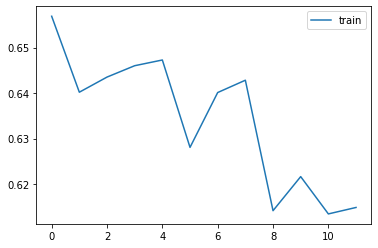

In [63]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()



In [64]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.5)      

Accuracy: 74.04%
Analyzing 104 samples
Threshold: 0.5
False Negative, prob: 0.28536584973335266
False Negative, prob: 0.2250484675168991
False Negative, prob: 0.32086339592933655
False Negative, prob: 0.2570270597934723
False Negative, prob: 0.3253635764122009
False Negative, prob: 0.26355549693107605
False Negative, prob: 0.3442333936691284
False Negative, prob: 0.3148510456085205
False Negative, prob: 0.24505846202373505
False Negative, prob: 0.31949183344841003
False Negative, prob: 0.32762065529823303
Profit: 373
False Negative, prob: 0.2326124757528305
False Negative, prob: 0.3226100206375122
False Negative, prob: 0.33607450127601624
Profit: -241
False Negative, prob: 0.23409084975719452
False Negative, prob: 0.2988980710506439
False Negative, prob: 0.26833420991897583
False Negative, prob: 0.25069698691368103
Profit: 631
False Negative, prob: 0.3206718862056732
False Negative, prob: 0.4092714488506317
Profit: -156
False Negative, prob: 0.24582023918628693
False Negative, prob: 0.

(0.5, 0.07407407407407407)

# Stacked LSTM - Non-Padded Inputs

In [114]:
nonpadded_pipe = Pipeline(
            steps=
            [
                ('min_max',MinMaxer()),
                ('transpose', Transposer())
            ])

In [115]:

buy_data_pipelined_non_padded = nonpadded_pipe.transform(buy_inputs)


train_perc = 0.8
buy_stop_index = round(len(buy_labels) * train_perc)
X_buy_train = buy_data_pipelined_non_padded[:buy_stop_index]
X_buy_test = buy_data_pipelined_non_padded[buy_stop_index:]
y_buy_train = buy_labels[:buy_stop_index]
y_buy_test = buy_labels[buy_stop_index:]
profit_buy_train = buy_profits[:buy_stop_index]
profit_buy_test = buy_profits[buy_stop_index:]

print(len(buy_data_pipelined_non_padded[0][0]))

46


In [116]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(None, X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

AttributeError: 'list' object has no attribute 'shape'

# Bidirectional LSTM

In [112]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(X_buy_train.shape[1], X_buy_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=20, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

    

AttributeError: 'list' object has no attribute 'shape'

In [113]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test)  

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

# Stacked Bidirectional LSTM

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 10, 200)           181600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 200)           240800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

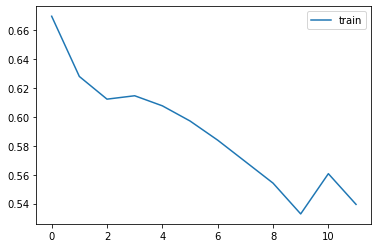

In [297]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), input_shape=(X_buy_train.shape[1], X_buy_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()



In [298]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

precision_recall(model, X_buy_test, y_buy_test, profit_buy_test)  

Accuracy: 73.91%
Threshold: 0.5
Profit: -170
Profit: 201
Profit: -161
Profit: 861
Profit: 269
The model guessed:
	3/13 profitable trades correctly (true positives)
	10/13 profitable trades incorrectly (false negatives)
	31/33 unprofitable trades correctly (true negatives)
	2/33 unprofitable trades incorrectly (false positives)
	 Precision: 0.6
	 Recall: 0.23076923076923078
	 Profit: 1000


(0.6, 0.23076923076923078)